# Ablation Study: Reconstruction Loss Comparison

This notebook performs an ablation study comparing reconstruction loss between
regular SAE and BatchTopK SAE models across different latent dimensions.

## Overview

The ablation study compares:
1. **Regular SAE**: Standard sparse autoencoder with L1 sparsity penalty
2. **BatchTopK SAE**: Sparse autoencoder with an explicit batch top-k sparsity constraint

We test different configurations:
- **Latent dimensions**: 100, 250, 500, 1000, 2000
- **TopK values**: 5, 10, 20 (for BatchTopK SAE)
- **Metrics**: Reconstruction loss, training time, L0 sparsity

## Goals
- Compare reconstruction quality and sparsity between regular and BatchTopK SAE
- Understand the impact of latent dimension size
- Evaluate sparsity patterns

## Setup and Imports

In [1]:
import sys
import os
from pathlib import Path
import time
import json
from typing import Dict, List, Tuple

# Add the src directory to the path
notebook_dir = Path.cwd()
src_path = notebook_dir.parent / "src"
sys.path.append(str(src_path))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn

# Import SAE components
from sae.pipeline import (
    SAETrainingPipeline, 
    run_complete_pipeline,
    BatchTopKSAETrainingPipeline, 
    run_complete_batchtopk_pipeline
)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Imports completed successfully!")
print(f"📁 Working directory: {notebook_dir}")
print(f"📁 Source path: {src_path}")

INFO:datasets:PyTorch version 2.6.0 available.


✅ Imports completed successfully!
📁 Working directory: /home/owkin/sae-project/SAE/notebooks
📁 Source path: /home/owkin/sae-project/SAE/src


## Configuration

Set up the ablation study parameters. You can modify these values to experiment with different configurations.

In [2]:
# Ablation study configuration
config = {
    'refseq_file': '../../data/vertebrate_mammalian.1.rna.gbff',  # Path to RefSeq file
    'max_samples': 200,  # Number of samples to use (smaller for faster experimentation)
    'latent_dims': [100, 250, 500, 1000],  # List of latent dimensions to test
    'epochs': 15,  # Number of training epochs (fewer for faster experimentation)
    'batch_size': 4,  # Batch size (reduced to avoid memory issues)
    'topk_values': [5, 10, 20],  # List of topk values to test for BatchTopK
    'layer_idx': None,  # Layer index to extract embeddings from (None for final layer)
    'layer_name': 'final',  # Layer name for identification
    'output_dir': '../outputs/ablation_study_reconstruction'  # Directory to save results
}

print("🔬 Ablation Study Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")

# Check if RefSeq file exists
refseq_path = Path(config['refseq_file'])
if refseq_path.exists():
    print(f"\n✅ RefSeq file found: {refseq_path}")
else:
    print(f"\n⚠️  RefSeq file not found: {refseq_path}")
    print("   Please update the 'refseq_file' path in the config above.")

# Create output directory
output_dir = Path(config['output_dir'])
output_dir.mkdir(parents=True, exist_ok=True)
print(f"\n📁 Output directory: {output_dir}")

🔬 Ablation Study Configuration:
   refseq_file: ../../data/vertebrate_mammalian.1.rna.gbff
   max_samples: 200
   latent_dims: [100, 250, 500, 1000]
   epochs: 15
   batch_size: 4
   topk_values: [5, 10, 20]
   layer_idx: None
   layer_name: final
   output_dir: ../outputs/ablation_study_reconstruction

✅ RefSeq file found: ../../data/vertebrate_mammalian.1.rna.gbff

📁 Output directory: ../outputs/ablation_study_reconstruction


## Results Storage

Initialize data structures to store the ablation study results.

In [3]:
# Results storage
results = {
    'regular_sae': {},
    'batchtopk_sae': {}
}

# L0 sparsity values storage
l0_values = {
    'regular_sae': {},
    'batchtopk_sae': {}
}

# Training times
training_times = {
    'regular_sae': {},
    'batchtopk_sae': {}
}

print("📊 Results storage initialized!")
print(f"   Regular SAE latent dims to test: {config['latent_dims']}")
print(f"   BatchTopK SAE combinations: {len(config['latent_dims']) * len(config['topk_values'])} total")
print(f"   Total experiments: {len(config['latent_dims']) + len(config['latent_dims']) * len(config['topk_values'])}")

📊 Results storage initialized!
   Regular SAE latent dims to test: [100, 250, 500, 1000]
   BatchTopK SAE combinations: 12 total
   Total experiments: 16


## Step 1: Regular SAE Experiments

Here we use the `run_complete_pipeline` function from `sae.pipeline` to run an entire SAE training pipeline, the same as was done in the `sae_pipeline_interactive.ipynb` notebook. We run experiments for the original SAE architecutre across a range of latent dimensions.

🚀 Running Regular SAE Experiments


Regular SAE:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff



📊 Testing Regular SAE with latent_dim=100
🚀 Starting Complete SAE Training Pipeline from final
1. Setting up embedding generator...
2. Preparing training data...


INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ SAE model setup complete: 256 -> 100
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting training for 15 epochs...


3. Setting up SAE model...
4. Setting up trainer...
5. Training SAE model...
Starting training for 15 epochs...
Epoch   1 | Train Loss: 0.015891 | Val Loss: 0.011973 | Val L0: 10.2
Epoch   2 | Train Loss: 0.009631 | Val Loss: 0.008449 | Val L0: 11.9
Epoch   3 | Train Loss: 0.007767 | Val Loss: 0.007484 | Val L0: 12.1
Epoch   4 | Train Loss: 0.007160 | Val Loss: 0.007012 | Val L0: 11.9
Epoch   5 | Train Loss: 0.006734 | Val Loss: 0.006562 | Val L0: 11.7
Epoch   6 | Train Loss: 0.006257 | Val Loss: 0.006057 | Val L0: 10.8
Epoch   7 | Train Loss: 0.005715 | Val Loss: 0.005495 | Val L0: 10.5
Epoch   8 | Train Loss: 0.005058 | Val Loss: 0.004774 | Val L0: 9.7
Epoch   9 | Train Loss: 0.004323 | Val Loss: 0.004107 | Val L0: 7.4
Epoch  10 | Train Loss: 0.003891 | Val Loss: 0.003816 | Val L0: 6.0
Epoch  11 | Train Loss: 0.003677 | Val Loss: 0.003624 | Val L0: 5.6
Epoch  12 | Train Loss: 0.003484 | Val Loss: 0.003439 | Val L0: 5.2
Epoch  13 | Train Loss: 0.003289 | Val Loss: 0.003252 | Val L0: 4

INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/regular_sae_latent_100/best_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/regular_sae_latent_100/best_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ Training completed!


Epoch  15 | Train Loss: 0.002905 | Val Loss: 0.002874 | Val L0: 4.1
Training completed!
6. Plotting training history...


INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ SAE model setup complete: 256 -> 250
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting training for 15 epochs...


✅ Pipeline completed successfully!
   ✅ Final validation reconstruction loss: 0.000403
   📊 Final validation L0 sparsity: 4.1
   ⏱️  Training time: 5.86s

📊 Testing Regular SAE with latent_dim=250
🚀 Starting Complete SAE Training Pipeline from final
1. Setting up embedding generator...
2. Preparing training data...
3. Setting up SAE model...
4. Setting up trainer...
5. Training SAE model...
Starting training for 15 epochs...
Epoch   1 | Train Loss: 0.010028 | Val Loss: 0.007313 | Val L0: 85.1
Epoch   2 | Train Loss: 0.006322 | Val Loss: 0.005599 | Val L0: 58.6
Epoch   3 | Train Loss: 0.004910 | Val Loss: 0.004413 | Val L0: 40.3
Epoch   4 | Train Loss: 0.003990 | Val Loss: 0.003723 | Val L0: 28.1
Epoch   5 | Train Loss: 0.003400 | Val Loss: 0.003133 | Val L0: 22.9
Epoch   6 | Train Loss: 0.002837 | Val Loss: 0.002637 | Val L0: 16.5
Epoch   7 | Train Loss: 0.002445 | Val Loss: 0.002324 | Val L0: 12.0
Epoch   8 | Train Loss: 0.002213 | Val Loss: 0.002098 | Val L0: 10.7
Epoch   9 | Train L

INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/regular_sae_latent_250/best_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/regular_sae_latent_250/best_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ Training completed!


Epoch  15 | Train Loss: 0.001358 | Val Loss: 0.001351 | Val L0: 6.1
Training completed!
6. Plotting training history...


INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ SAE model setup complete: 256 -> 500
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting training for 15 epochs...


✅ Pipeline completed successfully!
   ✅ Final validation reconstruction loss: 0.000194
   📊 Final validation L0 sparsity: 6.1
   ⏱️  Training time: 5.05s

📊 Testing Regular SAE with latent_dim=500
🚀 Starting Complete SAE Training Pipeline from final
1. Setting up embedding generator...
2. Preparing training data...
3. Setting up SAE model...
4. Setting up trainer...
5. Training SAE model...
Starting training for 15 epochs...
Epoch   1 | Train Loss: 0.006275 | Val Loss: 0.004396 | Val L0: 137.6
Epoch   2 | Train Loss: 0.003712 | Val Loss: 0.003231 | Val L0: 87.1
Epoch   3 | Train Loss: 0.002831 | Val Loss: 0.002560 | Val L0: 58.9
Epoch   4 | Train Loss: 0.002344 | Val Loss: 0.002211 | Val L0: 43.5
Epoch   5 | Train Loss: 0.002036 | Val Loss: 0.001926 | Val L0: 35.5
Epoch   6 | Train Loss: 0.001799 | Val Loss: 0.001729 | Val L0: 30.1
Epoch   7 | Train Loss: 0.001637 | Val Loss: 0.001585 | Val L0: 27.3
Epoch   8 | Train Loss: 0.001497 | Val Loss: 0.001446 | Val L0: 25.3
Epoch   9 | Train 

INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/regular_sae_latent_500/best_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/regular_sae_latent_500/best_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ Training completed!


Epoch  15 | Train Loss: 0.000961 | Val Loss: 0.000955 | Val L0: 17.0
Training completed!
6. Plotting training history...


INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ SAE model setup complete: 256 -> 1000
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting training for 15 epochs...


✅ Pipeline completed successfully!
   ✅ Final validation reconstruction loss: 0.000109
   📊 Final validation L0 sparsity: 17.0
   ⏱️  Training time: 5.68s

📊 Testing Regular SAE with latent_dim=1000
🚀 Starting Complete SAE Training Pipeline from final
1. Setting up embedding generator...
2. Preparing training data...
3. Setting up SAE model...
4. Setting up trainer...
5. Training SAE model...
Starting training for 15 epochs...
Epoch   1 | Train Loss: 0.003763 | Val Loss: 0.002632 | Val L0: 217.3
Epoch   2 | Train Loss: 0.002207 | Val Loss: 0.001885 | Val L0: 144.7
Epoch   3 | Train Loss: 0.001626 | Val Loss: 0.001436 | Val L0: 99.9
Epoch   4 | Train Loss: 0.001275 | Val Loss: 0.001151 | Val L0: 78.6
Epoch   5 | Train Loss: 0.001032 | Val Loss: 0.000958 | Val L0: 63.5
Epoch   6 | Train Loss: 0.000875 | Val Loss: 0.000827 | Val L0: 54.5
Epoch   7 | Train Loss: 0.000764 | Val Loss: 0.000729 | Val L0: 47.0
Epoch   8 | Train Loss: 0.000679 | Val Loss: 0.000653 | Val L0: 42.6
Epoch   9 | Tra

INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/regular_sae_latent_1000/best_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/regular_sae_latent_1000/best_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ Training completed!


Epoch  15 | Train Loss: 0.000432 | Val Loss: 0.000434 | Val L0: 28.1
Training completed!
6. Plotting training history...
✅ Pipeline completed successfully!
   ✅ Final validation reconstruction loss: 0.000057
   📊 Final validation L0 sparsity: 28.1
   ⏱️  Training time: 6.72s

✅ Regular SAE experiments completed!


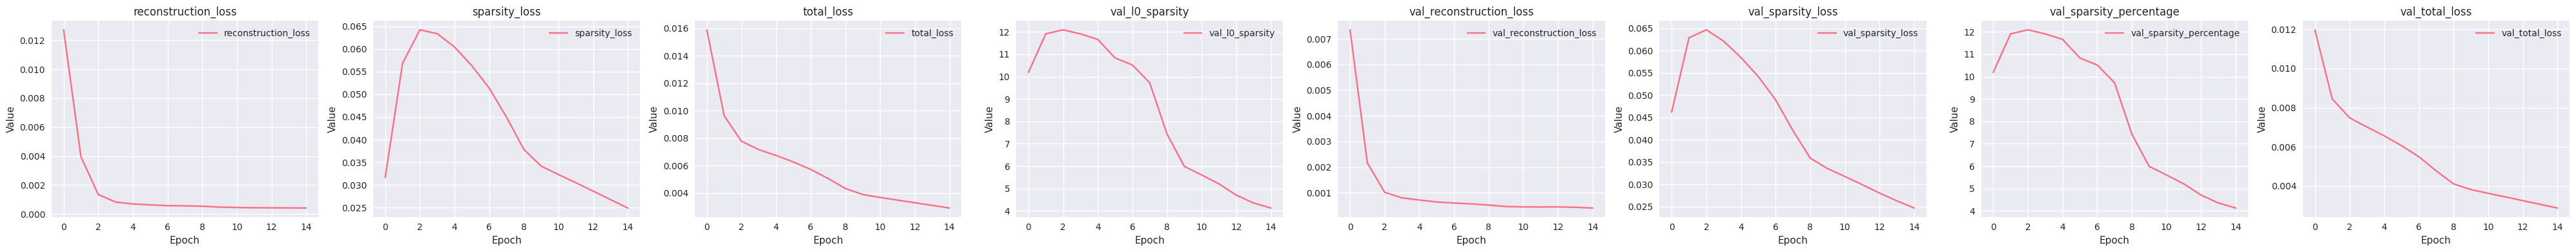

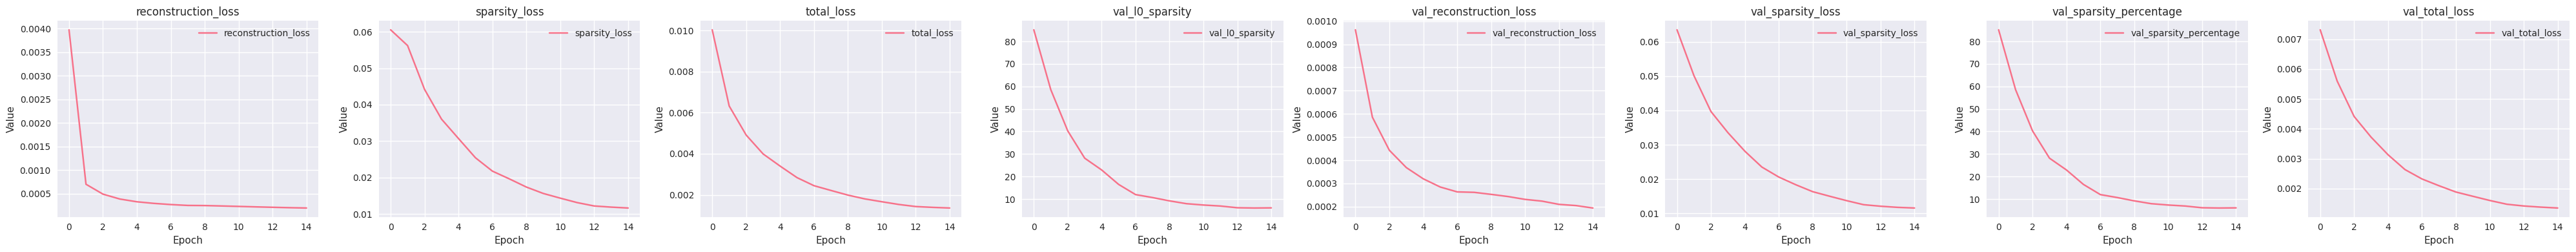

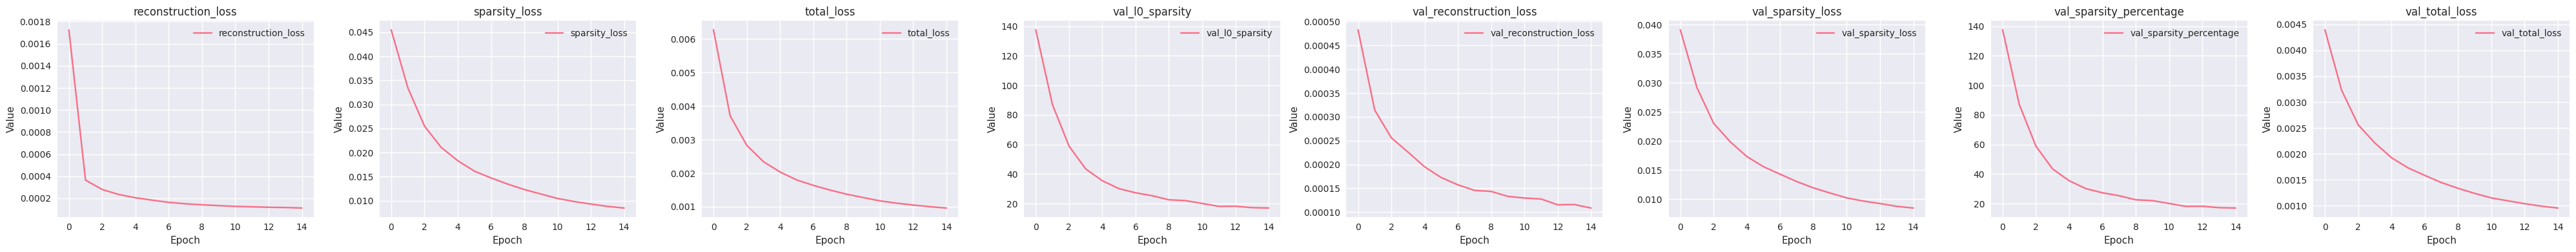

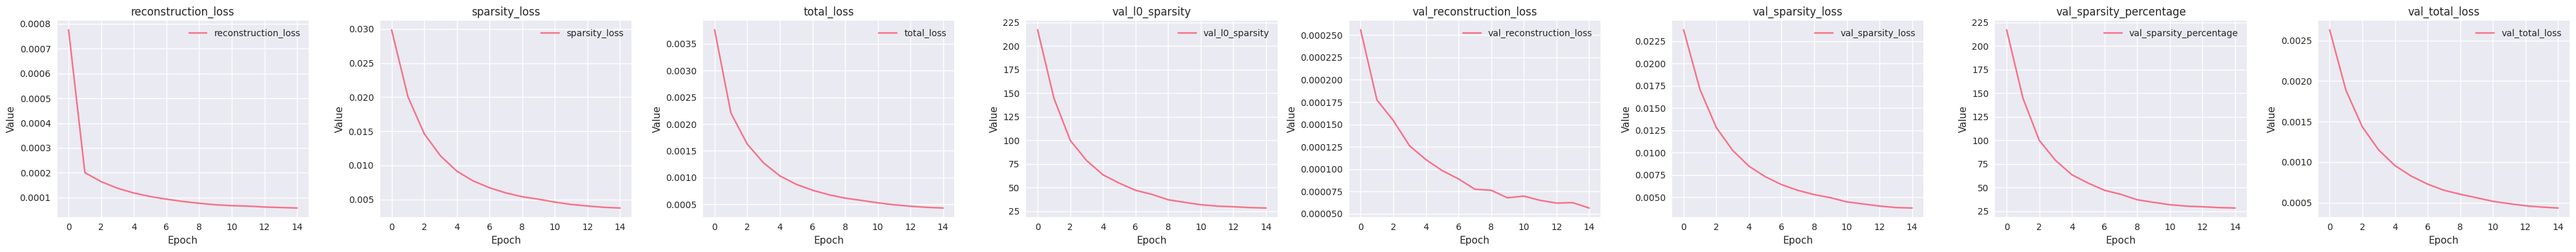

In [4]:
print("🚀 Running Regular SAE Experiments")
print("=" * 50)

for latent_dim in tqdm(config['latent_dims'], desc="Regular SAE"):
    print(f"\n📊 Testing Regular SAE with latent_dim={latent_dim}")
    
    try:
        start_time = time.time()
        
        # Run regular SAE pipeline
        pipeline = run_complete_pipeline(
            refseq_file=config['refseq_file'],
            max_samples=config['max_samples'],
            embedding_dim=None,  # Auto-detect
            hidden_dim=latent_dim,
            epochs=config['epochs'],
            batch_size=config['batch_size'],
            layer_idx=config['layer_idx'],
            layer_name=config['layer_name'],
            cache_dir=str(output_dir / "regular_sae_cache"),
            model_save_dir=str(output_dir / f"regular_sae_latent_{latent_dim}")
        )
        
        training_time = time.time() - start_time
        training_times['regular_sae'][latent_dim] = training_time
        
        # Get final validation reconstruction loss and L0 sparsity
        final_val_reconstruction_loss = None
        final_val_l0 = None
        
        # Try to get from stored training history first
        if hasattr(pipeline, '_last_training_history') and pipeline._last_training_history:
            if pipeline._last_training_history.get('val_reconstruction_loss'):
                final_val_reconstruction_loss = pipeline._last_training_history['val_reconstruction_loss'][-1]
            if pipeline._last_training_history.get('val_l0_sparsity'):
                final_val_l0 = pipeline._last_training_history['val_l0_sparsity'][-1]
        
        # Fallback: try to get from trainer training history
        if final_val_reconstruction_loss is None and hasattr(pipeline, 'trainer') and pipeline.trainer and hasattr(pipeline.trainer, 'training_history'):
            if pipeline.trainer.training_history:
                final_val_reconstruction_loss = pipeline.trainer.training_history[-1].get('val_reconstruction_loss')
                final_val_l0 = pipeline.trainer.training_history[-1].get('val_l0_sparsity')
        
        if final_val_reconstruction_loss is not None:
            results['regular_sae'][latent_dim] = final_val_reconstruction_loss
            if final_val_l0 is not None:
                l0_values['regular_sae'][latent_dim] = final_val_l0
            print(f"   ✅ Final validation reconstruction loss: {final_val_reconstruction_loss:.6f}")
            if final_val_l0 is not None:
                print(f"   📊 Final validation L0 sparsity: {final_val_l0:.1f}")
            print(f"   ⏱️  Training time: {training_time:.2f}s")
        else:
            print(f"   ❌ No validation reconstruction loss recorded")
            
    except Exception as e:
        print(f"   ❌ Error: {e}")
        results['regular_sae'][latent_dim] = None

print("\n✅ Regular SAE experiments completed!")

## Step 2: BatchTopK SAE Experiments

There has been much work on improving the trainability of sparse autoencoders with very large latent dimension while maintaining a sparse latent code \[Gao et al., 2024\]. We take inspiration from several of these works to try to build an SAE more effective at learning mono-semantic latents, calling it BatchTopK SAE.

The main innovation of BatchTopK SAE (available as the `BatchTopK SAE` class in `sae.models`) is to use BatchTopK (zeroing all but the `k * len_batch` activations) activation function in place of the standard ReLU. Thus L0 loss and latent sparsity is enforced explicitly while still allowing the latents to have variable expressive power. This also allows uss to replace the `SAELoss`with a standard MSE reconstruction loss.

There are also small changed to the forward function, weight initialization, and weight updates intended to improve training.

In [5]:
class BatchTopK(nn.Module):
    """
    BatchTopK is a module that zeros all values except the top-k values in the batch.
    """
    def __init__(self, topk):
        super().__init__()
        self.topk = topk

    def forward(self, x):
        original_shape = x.shape
        x_flat = x.view(-1)

        # Get top-k values and their indices
        topk_values, topk_indices = x_flat.topk(min(self.topk * original_shape[0], x_flat.numel()))

        # Create zero tensor
        result = torch.zeros_like(x_flat)

        # Set top-k values
        result[topk_indices] = topk_values

        # Reshape back to original shape
        return result.view(original_shape)

class BatchTopKSAE(nn.Module):
    def __init__(self, input_size, hidden_size, sparsity_weight=0.01, sparsity_target=0.05, topk=10):
        """
        SAE model with tied encoder and decoder
        Parameters:
            input_size: int, the dimension of the input data
            hidden_size: int, the dimension of the hidden layer
            sparsity_weight: float, weight for sparsity penalty
            sparsity_target: float, target sparsity level
            topk: int, number of top values to keep in BatchTopK
        Returns:
            SAE model
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sparsity_weight = sparsity_weight
        self.sparsity_target = sparsity_target

        self.encoder = nn.Linear(input_size, hidden_size, bias=False)
        self.pre_bias = nn.Parameter(torch.zeros(input_size))
        self.encoder_bias = nn.Parameter(torch.zeros(hidden_size))

        # Initialize BatchTopK with a default batch_size (will be updated during forward pass)
        self.topk_layer = BatchTopK(topk)

        self.decoder = nn.Linear(hidden_size, input_size, bias=False)
        self.loss_fn = nn.MSELoss()

        # Initialize weights
        self._init_weights()

    def forward(self, x):
        original_shape = x.shape

        # Flatten if 3D input
        if x.dim() == 3:
            batch_size, seq_len, embed_dim = x.shape
            x = x.view(-1, embed_dim)


        x = x - self.pre_bias
        x = self.encoder(x)
        x = x + self.encoder_bias
        z = self.topk_layer(x)
        x = self.decoder(z)
        x = x + self.pre_bias

        # Reshape back to original shape if needed
        if len(original_shape) == 3:
            x = x.view(original_shape)
            z = z.view(batch_size, seq_len, -1)  # Reshape encoded to match original

        # Return (reconstructed, encoded) to match regular SAE interface
        return x, z


Here we run experiments for BatchTopK SAE across different latent dimensions and topk values.

🚀 Running BatchTopK SAE Experiments


BatchTopK SAE:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff



📊 Testing BatchTopK SAE with latent_dim=100, topk=5
🚀 Starting Complete BatchTopK SAE Training Pipeline from final
1. Setting up embedding generator...
2. Preparing training data...


INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 100 (topk=5)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


3. Setting up BatchTopK SAE model...
4. Setting up trainer...
5. Training BatchTopK SAE model...


INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001489, Val Loss = 0.001666
Training BatchTopK SAE: 100%|██████████| 15/15 [00:20<00:00,  1.39s/epoch, Train Loss=0.001529, Val Loss=0.001705]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_100_topk_5/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_100_topk_5/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


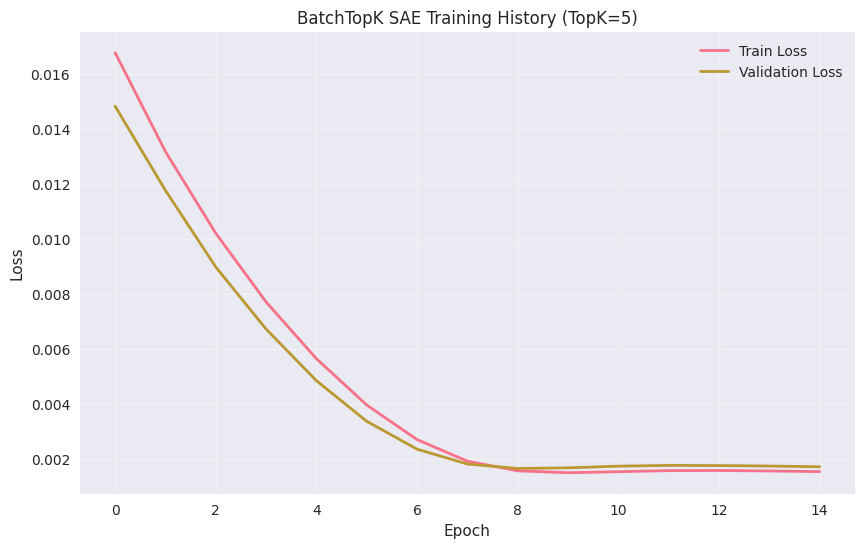

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 100 (topk=10)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001423, Val Loss = 0.001601
Training BatchTopK SAE: 100%|██████████| 15/15 [00:20<00:00,  1.38s/epoch, Train Loss=0.001424, Val Loss=0.001585]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_100_topk_10/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_100_topk_10/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


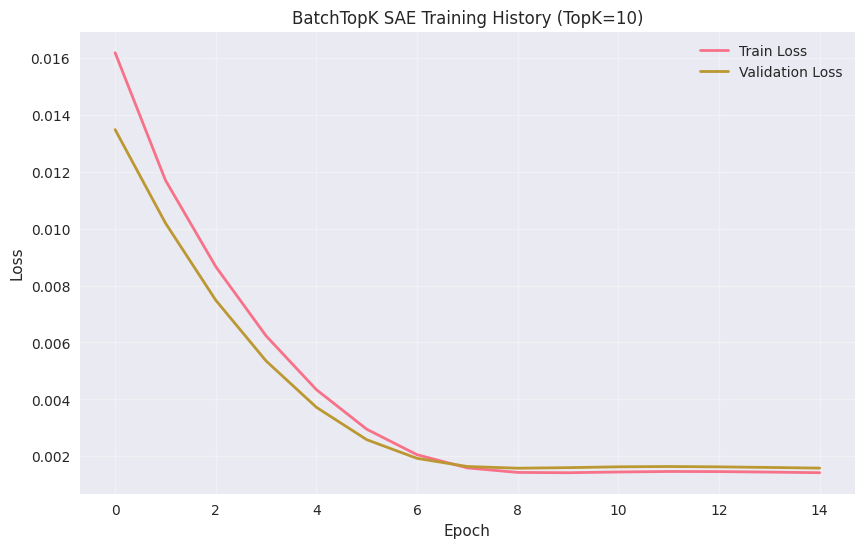

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 100 (topk=20)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001419, Val Loss = 0.001592
Training BatchTopK SAE: 100%|██████████| 15/15 [00:20<00:00,  1.38s/epoch, Train Loss=0.001396, Val Loss=0.001508]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_100_topk_20/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_100_topk_20/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


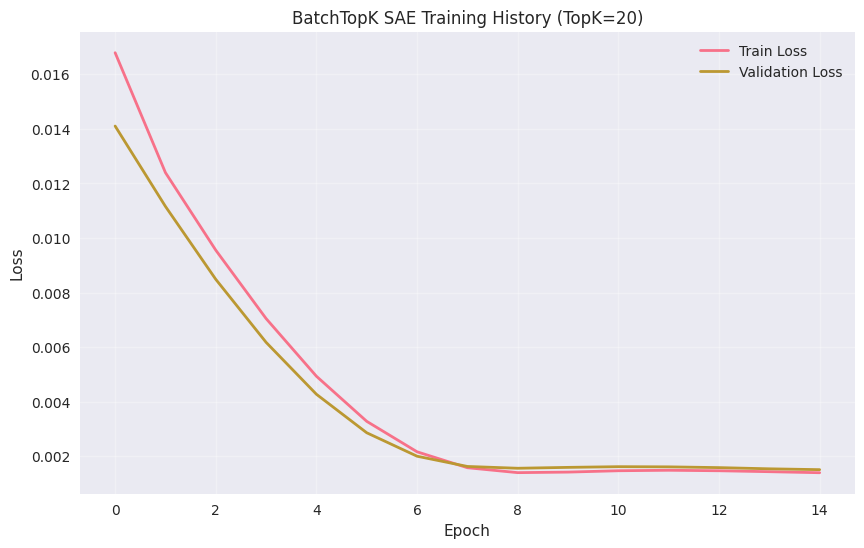

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 250 (topk=5)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001628, Val Loss = 0.001751
Training BatchTopK SAE: 100%|██████████| 15/15 [00:21<00:00,  1.41s/epoch, Train Loss=0.001387, Val Loss=0.001535]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_250_topk_5/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_250_topk_5/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


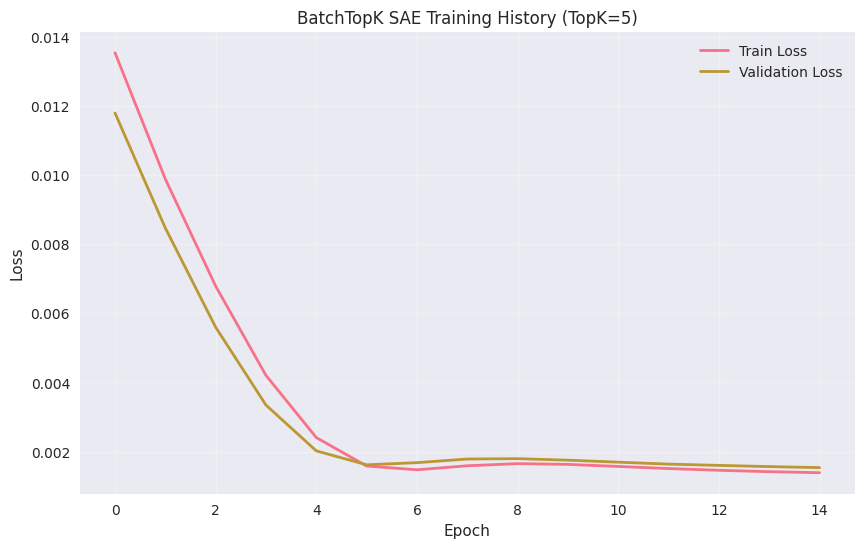

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 250 (topk=10)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001561, Val Loss = 0.001705
Training BatchTopK SAE: 100%|██████████| 15/15 [00:20<00:00,  1.38s/epoch, Train Loss=0.001300, Val Loss=0.001457]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_250_topk_10/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_250_topk_10/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


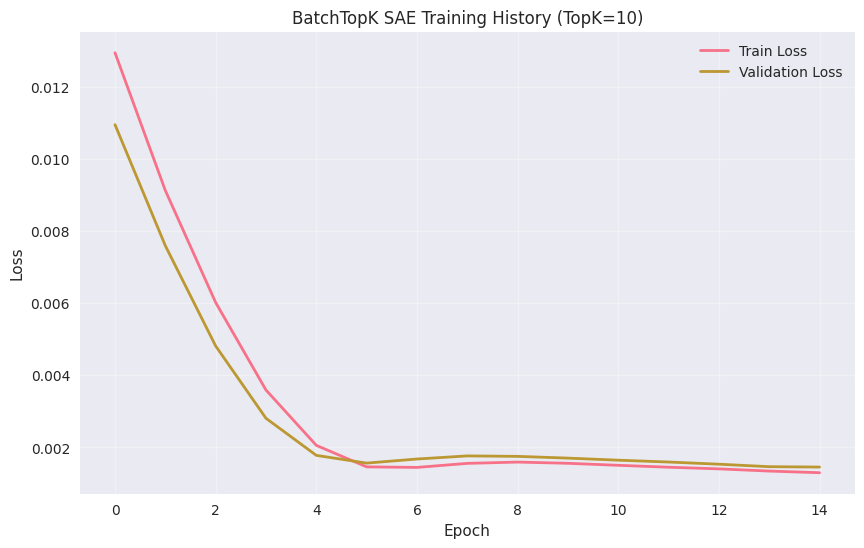

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 250 (topk=20)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001333, Val Loss = 0.001474
Training BatchTopK SAE: 100%|██████████| 15/15 [00:20<00:00,  1.38s/epoch, Train Loss=0.001160, Val Loss=0.001292]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_250_topk_20/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_250_topk_20/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


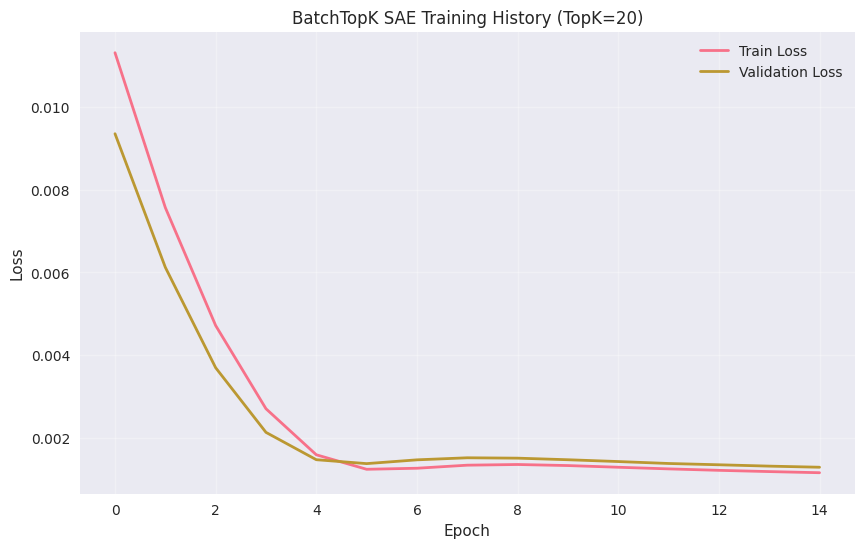

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 500 (topk=5)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001505, Val Loss = 0.001584
Training BatchTopK SAE: 100%|██████████| 15/15 [00:21<00:00,  1.42s/epoch, Train Loss=0.001242, Val Loss=0.001407]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_500_topk_5/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_500_topk_5/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


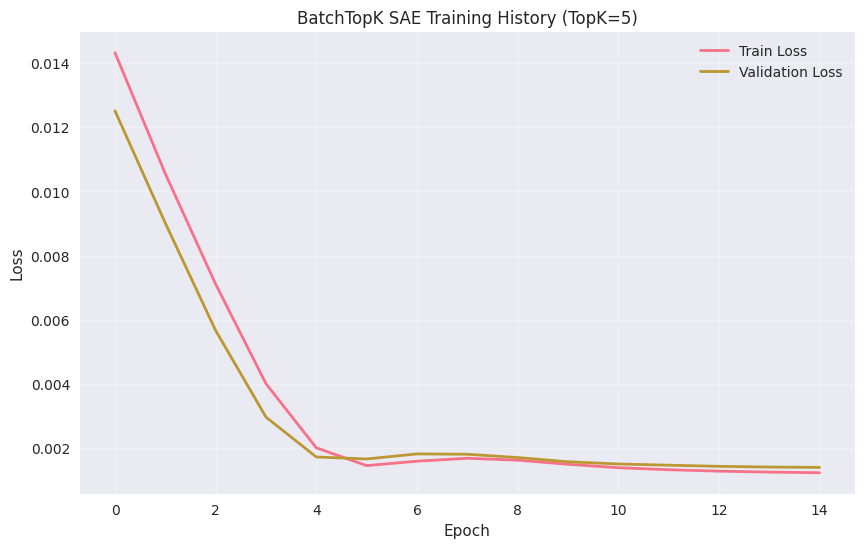

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 500 (topk=10)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001390, Val Loss = 0.001502
Training BatchTopK SAE: 100%|██████████| 15/15 [00:21<00:00,  1.41s/epoch, Train Loss=0.001126, Val Loss=0.001258]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_500_topk_10/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_500_topk_10/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


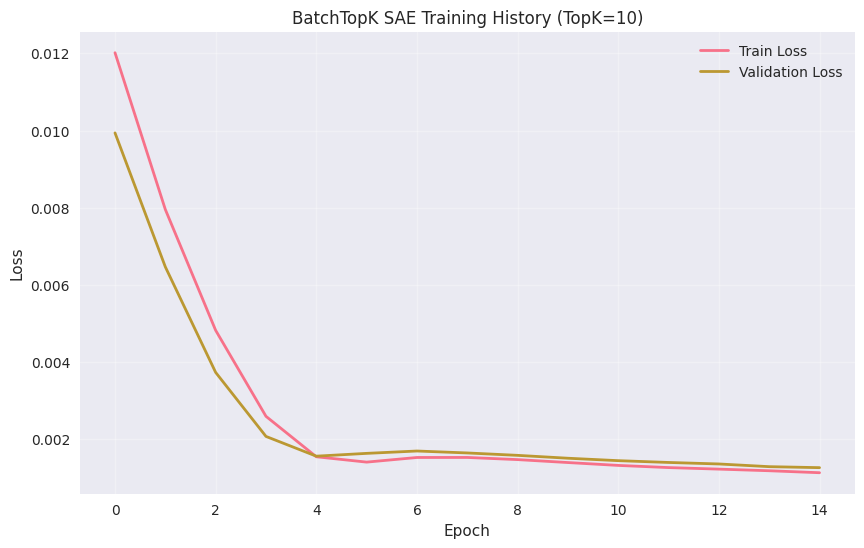

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 500 (topk=20)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001176, Val Loss = 0.001246
Training BatchTopK SAE: 100%|██████████| 15/15 [00:21<00:00,  1.41s/epoch, Train Loss=0.000999, Val Loss=0.001129]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_500_topk_20/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_500_topk_20/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


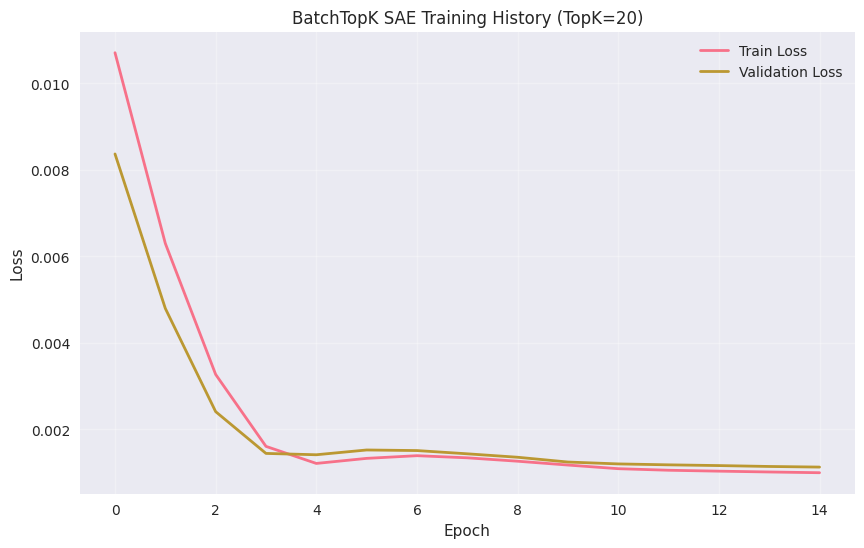

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 1000 (topk=5)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001322, Val Loss = 0.001462
Training BatchTopK SAE: 100%|██████████| 15/15 [00:21<00:00,  1.46s/epoch, Train Loss=0.001188, Val Loss=0.001364]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_1000_topk_5/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_1000_topk_5/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


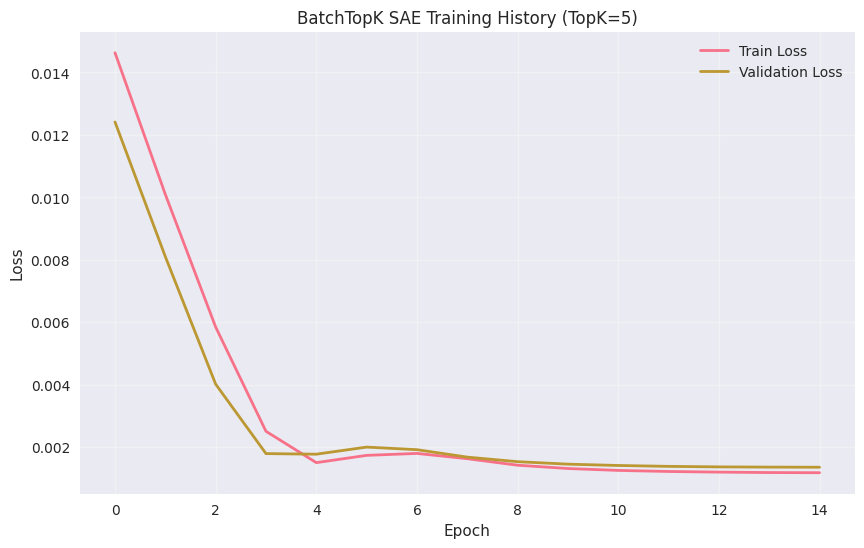

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 1000 (topk=10)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001201, Val Loss = 0.001312
Training BatchTopK SAE: 100%|██████████| 15/15 [00:21<00:00,  1.44s/epoch, Train Loss=0.000988, Val Loss=0.001103]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_1000_topk_10/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_1000_topk_10/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


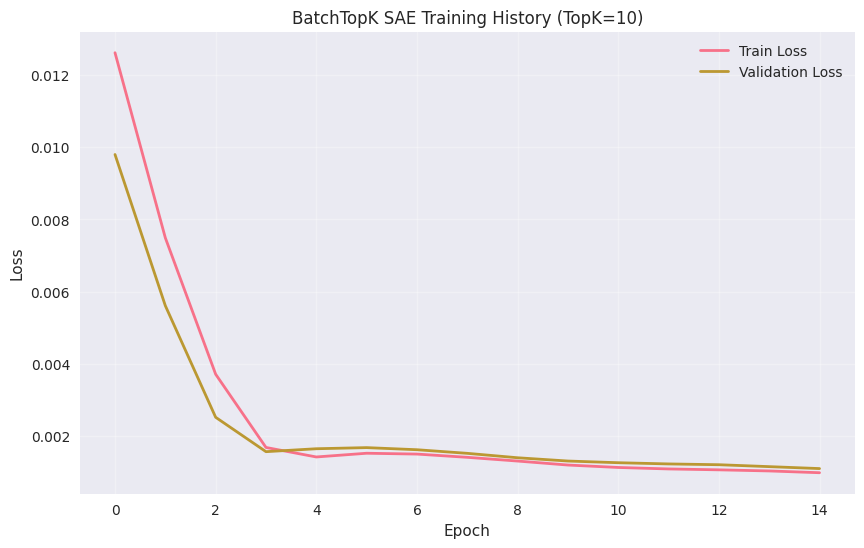

INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.base_pipeline:Generating embeddings from RefSeq_vertebrate_mammalian.1.rna from final: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.pipeline.embedding_generator:✅ Loaded RefSeq embeddings from cache: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Generated embeddings shape: (200, 1024, 256)
INFO:sae.pipeline.base_pipeline:Auto-detected embedding dimension: 256
INFO:sae.pipeline.base_pipeline:✅ Data prepared: 40 train batches, 10 val batches
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE model setup complete: 256 -> 1000 (topk=20)
INFO:sae.pipeline.base_pipeline:✅ Trainer setup complete
INFO:sae.pipeline.base_pipeline:Starting BatchTopK SAE training for 15 epochs...


✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

INFO:sae.pipeline.base_pipeline:Epoch 10/15: Train Loss = 0.001023, Val Loss = 0.001135
Training BatchTopK SAE: 100%|██████████| 15/15 [00:21<00:00,  1.45s/epoch, Train Loss=0.000807, Val Loss=0.000927]
INFO:sae.pipeline.base_pipeline:✅ Model saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_1000_topk_20/best_batchtopk_model.pth
INFO:sae.pipeline.base_pipeline:✅ Layer metadata saved to ../outputs/ablation_study_reconstruction/batchtopk_sae_latent_1000_topk_20/best_batchtopk_model.metadata.json
INFO:sae.pipeline.base_pipeline:✅ BatchTopK SAE training completed!


6. Plotting training history...


INFO:sae.pipeline.base_pipeline:✅ Training history plot saved to outputs/batchtopk_training_history.png


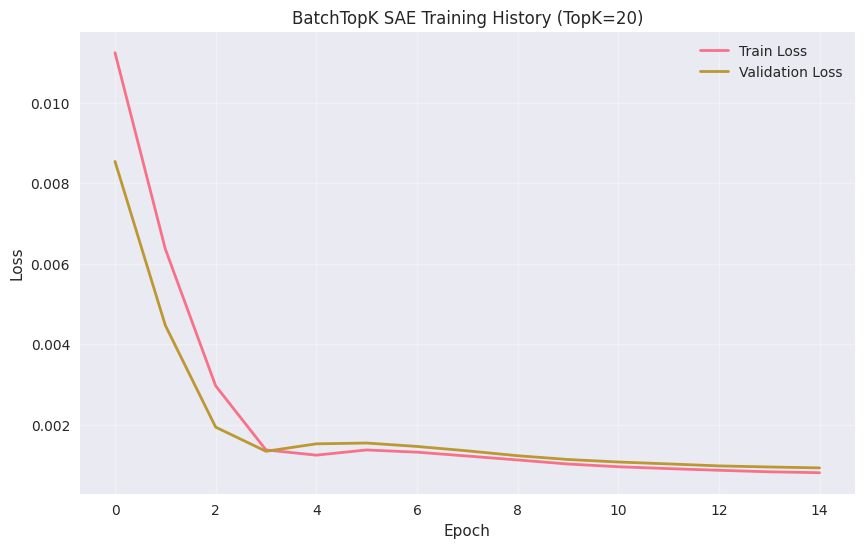

✅ BatchTopK SAE Pipeline completed successfully!
   �� Debugging BatchTopK pipeline structure...
   Pipeline type: <class 'sae.pipeline.batchtopk_pipeline.BatchTopKSAETrainingPipeline'>
   Pipeline attributes: ['cache_dir', 'device', 'embedding_dim', 'embedding_generator', 'extract_features', 'hidden_dim', 'layer_idx', 'layer_name', 'learning_rate', 'load_from_checkpoint', 'load_model', 'logger', 'model_save_dir', 'plot_training_history', 'prepare_data', 'run_complete_pipeline', 'sae_model', 'save_model', 'setup_embedding_generator', 'setup_sae_model', 'setup_trainer', 'sparsity_target', 'sparsity_weight', 'topk', 'train', 'trainer', 'training_config']
   Trainer type: <class 'sae.training.trainer.SAETrainer'>
   Trainer attributes: ['best_val_loss', 'callbacks', 'config', 'current_epoch', 'current_step', 'load_model', 'logger', 'loss_fn', 'model', 'optimizer', 'save_model', 'train', 'train_epoch', 'train_loader', 'training_history', 'val_loader', 'validate']
   Training history: []
  

In [6]:
print("🚀 Running BatchTopK SAE Experiments")
print("=" * 50)

for latent_dim in tqdm(config['latent_dims'], desc="BatchTopK SAE"):
    for topk in config['topk_values']:
        print(f"\n📊 Testing BatchTopK SAE with latent_dim={latent_dim}, topk={topk}")
        
        try:
            start_time = time.time()
            
            # Run BatchTopK SAE pipeline
            pipeline = run_complete_batchtopk_pipeline(
                refseq_file=config['refseq_file'],
                max_samples=config['max_samples'],
                embedding_dim=None,  # Auto-detect
                hidden_dim=latent_dim,
                topk=topk,
                epochs=config['epochs'],
                batch_size=config['batch_size'],
                layer_idx=config['layer_idx'],
                layer_name=config['layer_name'],
                cache_dir=str(output_dir / "batchtopk_sae_cache"),
                model_save_dir=str(output_dir / f"batchtopk_sae_latent_{latent_dim}_topk_{topk}")
            )
            
            # Replace the section after the pipeline call with this debugging code:

            training_time = time.time() - start_time
            training_times['batchtopk_sae'][(latent_dim, topk)] = training_time

            # Debug: Inspect pipeline structure
            print(f"   �� Debugging BatchTopK pipeline structure...")
            print(f"   Pipeline type: {type(pipeline)}")
            print(f"   Pipeline attributes: {[attr for attr in dir(pipeline) if not attr.startswith('_')]}")

            if hasattr(pipeline, 'trainer'):
                print(f"   Trainer type: {type(pipeline.trainer)}")
                if pipeline.trainer:
                    print(f"   Trainer attributes: {[attr for attr in dir(pipeline.trainer) if not attr.startswith('_')]}")
                    if hasattr(pipeline.trainer, 'training_history'):
                        print(f"   Training history: {pipeline.trainer.training_history}")
                    if hasattr(pipeline.trainer, 'logger'):
                        print(f"   Logger attributes: {[attr for attr in dir(pipeline.trainer.logger) if not attr.startswith('_')]}")
                        if hasattr(pipeline.trainer.logger, 'val_losses'):
                            print(f"   Logger val_losses: {pipeline.trainer.logger.val_losses}")

            if hasattr(pipeline, '_last_training_history'):
                print(f"   _last_training_history: {pipeline._last_training_history}")

            # Get final validation reconstruction loss
            final_val_reconstruction_loss = None

            # Try to get from trainer training history first
            if hasattr(pipeline, 'trainer') and pipeline.trainer and hasattr(pipeline.trainer, 'training_history'):
                if pipeline.trainer.training_history:
                    final_val_reconstruction_loss = pipeline.trainer.training_history[-1].get('val_reconstruction_loss')
                    print(f"   Found in trainer.training_history: {final_val_reconstruction_loss}")

            # If not found, try to get from custom training history
            if final_val_reconstruction_loss is None and hasattr(pipeline, '_last_training_history') and pipeline._last_training_history:
                if pipeline._last_training_history.get('val_reconstruction_loss'):
                    final_val_reconstruction_loss = pipeline._last_training_history['val_reconstruction_loss'][-1]
                    print(f"   Found in _last_training_history: {final_val_reconstruction_loss}")

            # Try to get from trainer logger
            if final_val_reconstruction_loss is None and hasattr(pipeline, 'trainer') and pipeline.trainer and hasattr(pipeline.trainer, 'logger'):
                if hasattr(pipeline.trainer.logger, 'val_losses') and pipeline.trainer.logger.val_losses:
                    final_val_reconstruction_loss = pipeline.trainer.logger.val_losses[-1]
                    print(f"   Found in trainer.logger.val_losses: {final_val_reconstruction_loss}")

            # Try to get from model directly
            if final_val_reconstruction_loss is None and hasattr(pipeline, 'model'):
                print(f"   Model type: {type(pipeline.model)}")
                print(f"   Model attributes: {[attr for attr in dir(pipeline.model) if not attr.startswith('_')]}")

            if final_val_reconstruction_loss is not None:
                results['batchtopk_sae'][(latent_dim, topk)] = final_val_reconstruction_loss
                print(f"   ✅ Final validation reconstruction loss: {final_val_reconstruction_loss:.6f}")
                print(f"   ⏱️  Training time: {training_time:.2f}s")
            else:
                print(f"   ❌ No validation reconstruction loss recorded")
                
        except Exception as e:
            print(f"   ❌ Error: {e}")
            results['batchtopk_sae'][(latent_dim, topk)] = None

print("\n✅ BatchTopK SAE experiments completed!")

## Step 3: Create Comparison DataFrame

Create a pandas DataFrame for easy analysis and plotting.

In [7]:
print("📊 Creating comparison DataFrame...")

data = []

# Add regular SAE results
for latent_dim, loss in results['regular_sae'].items():
    if loss is not None:
        data.append({
            'Model': 'Regular SAE',
            'Latent_Dim': latent_dim,
            'TopK': None,
            'Reconstruction_Loss': loss,
            'Training_Time': training_times['regular_sae'].get(latent_dim, None)
        })

# Add BatchTopK SAE results
for (latent_dim, topk), loss in results['batchtopk_sae'].items():
    if loss is not None:
        data.append({
            'Model': 'BatchTopK SAE',
            'Latent_Dim': latent_dim,
            'TopK': topk,
            'Reconstruction_Loss': loss,
            'Training_Time': training_times['batchtopk_sae'].get((latent_dim, topk), None)
        })

df = pd.DataFrame(data)

print("✅ DataFrame created!")
print(f"   Total results: {len(df)}")
print(f"   Models: {df['Model'].nunique()}")
print(f"   Latent dimensions: {df['Latent_Dim'].nunique()}")
print(f"   TopK values: {df['TopK'].nunique() - 1}")

# Display results
print("\n📋 Results Summary:")
print(df.groupby('Model')['Reconstruction_Loss'].agg(['count', 'mean', 'min', 'max']))

# Show detailed results
print("\n📊 Detailed Results:")
print(df.sort_values(['Model', 'Latent_Dim', 'TopK']))

📊 Creating comparison DataFrame...
✅ DataFrame created!
   Total results: 16
   Models: 2
   Latent dimensions: 4
   TopK values: 2

📋 Results Summary:
               count      mean       min       max
Model                                             
BatchTopK SAE     12  0.001356  0.000927  0.001705
Regular SAE        4  0.000191  0.000057  0.000403

📊 Detailed Results:
            Model  Latent_Dim  TopK  Reconstruction_Loss  Training_Time
4   BatchTopK SAE         100   5.0             0.001705      22.214038
5   BatchTopK SAE         100  10.0             0.001585      21.504392
6   BatchTopK SAE         100  20.0             0.001508      21.430250
7   BatchTopK SAE         250   5.0             0.001535      21.892759
8   BatchTopK SAE         250  10.0             0.001457      21.493598
9   BatchTopK SAE         250  20.0             0.001292      21.461114
10  BatchTopK SAE         500   5.0             0.001407      22.037923
11  BatchTopK SAE         500  10.0            

## Step 4: Create Visualization Plots

Let's create some plots of the ablation study results!

📊 Creating visualization plots...


   📈 Plot saved to: ../outputs/ablation_study_reconstruction/ablation_study_results.png


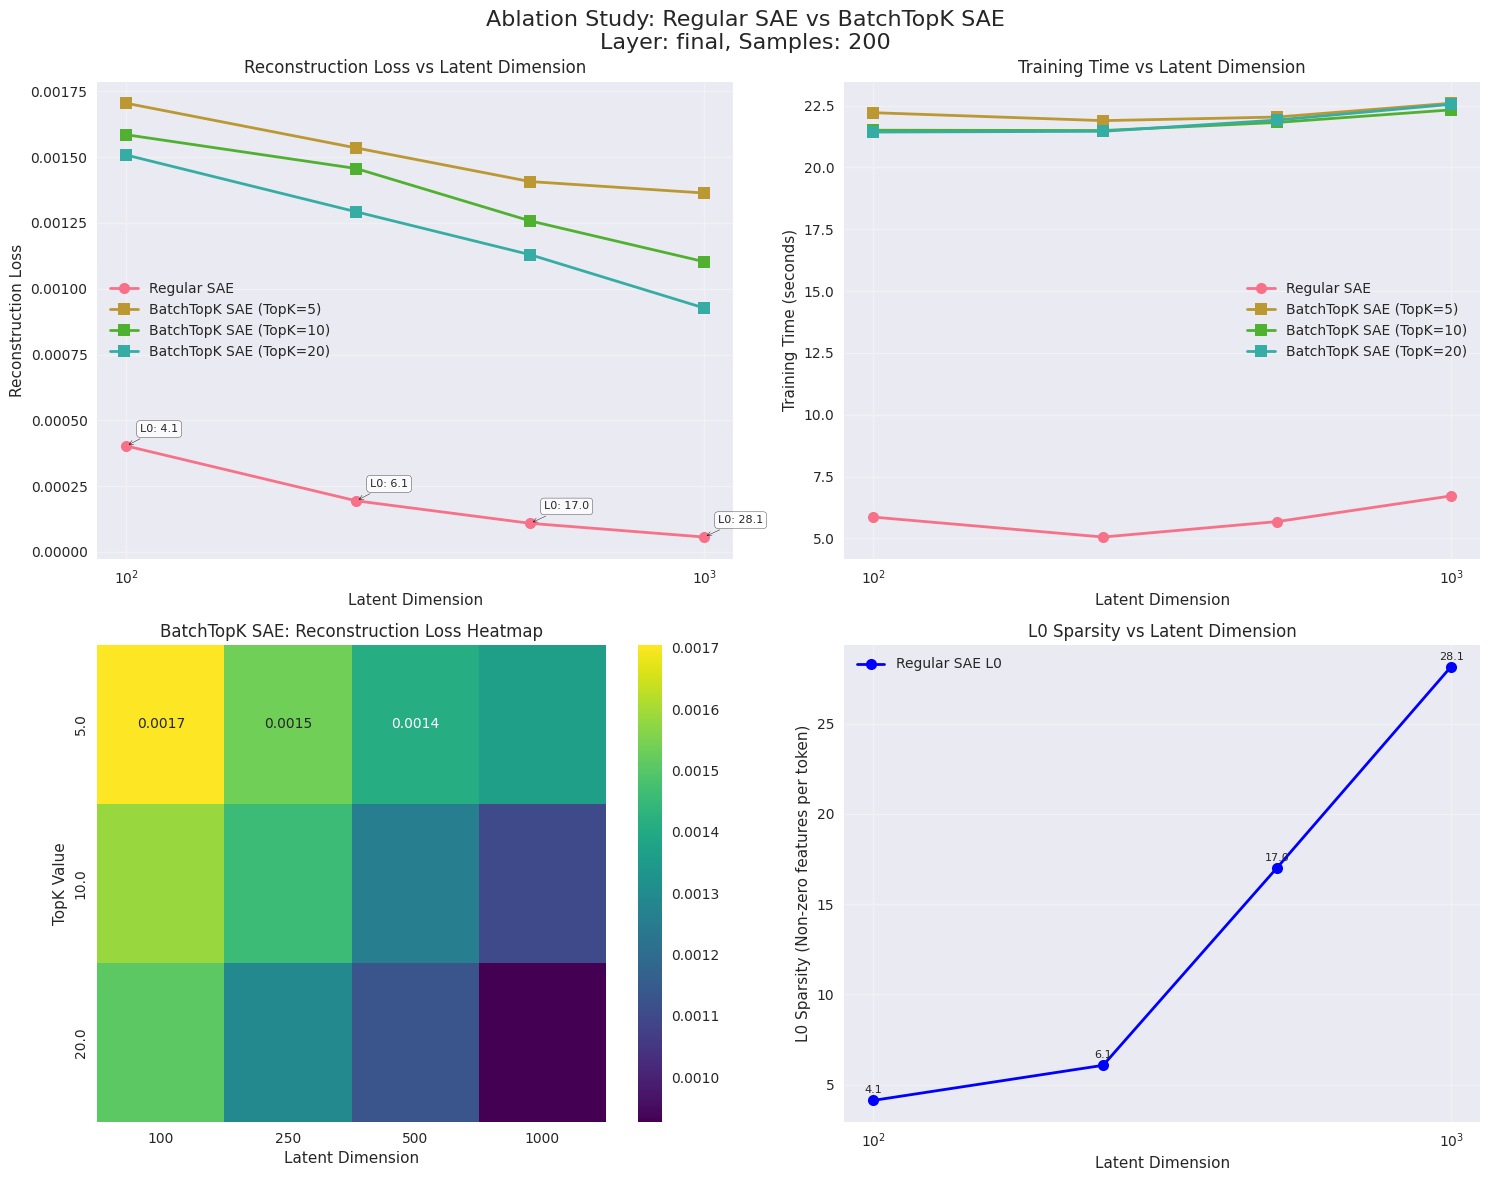

In [8]:
print("📊 Creating visualization plots...")

# Set up the plotting style
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Ablation Study: Regular SAE vs BatchTopK SAE\nLayer: {config["layer_name"]}, Samples: {config["max_samples"]}', fontsize=16)

# 1. Reconstruction Loss vs Latent Dimension
ax1 = axes[0, 0]
for model in ['Regular SAE', 'BatchTopK SAE']:
    model_data = df[df['Model'] == model]
    if model == 'Regular SAE':
        line = ax1.plot(model_data['Latent_Dim'], model_data['Reconstruction_Loss'], 
                'o-', label=model, linewidth=2, markersize=8)
        
        # Add L0 annotations for Regular SAE points
        for idx, row in model_data.iterrows():
            latent_dim = row['Latent_Dim']
            loss = row['Reconstruction_Loss']
            l0_val = l0_values['regular_sae'].get(latent_dim)
            if l0_val is not None:
                ax1.annotate(f'L0: {l0_val:.1f}', 
                           xy=(latent_dim, loss), 
                           xytext=(10, 10), 
                           textcoords='offset points',
                           fontsize=8, 
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    else:
        # For BatchTopK, plot each topk value separately
        for topk in config['topk_values']:
            topk_data = model_data[model_data['TopK'] == topk]
            if not topk_data.empty:
                ax1.plot(topk_data['Latent_Dim'], topk_data['Reconstruction_Loss'], 
                        's-', label=f'{model} (TopK={topk})', linewidth=2, markersize=8)

ax1.set_xlabel('Latent Dimension')
ax1.set_ylabel('Reconstruction Loss')
ax1.set_title('Reconstruction Loss vs Latent Dimension')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# 2. Training Time vs Latent Dimension
ax2 = axes[0, 1]
for model in ['Regular SAE', 'BatchTopK SAE']:
    model_data = df[df['Model'] == model]
    if model == 'Regular SAE':
        ax2.plot(model_data['Latent_Dim'], model_data['Training_Time'], 
                'o-', label=model, linewidth=2, markersize=8)
    else:
        # For BatchTopK, plot each topk value separately
        for topk in config['topk_values']:
            topk_data = model_data[model_data['TopK'] == topk]
            if not topk_data.empty:
                ax2.plot(topk_data['Latent_Dim'], topk_data['Training_Time'], 
                        's-', label=f'{model} (TopK={topk})', linewidth=2, markersize=8)

ax2.set_xlabel('Latent Dimension')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Training Time vs Latent Dimension')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

# 3. Heatmap of BatchTopK results
ax3 = axes[1, 0]
batchtopk_data = df[df['Model'] == 'BatchTopK SAE']
if not batchtopk_data.empty:
    pivot_data = batchtopk_data.pivot(index='TopK', columns='Latent_Dim', values='Reconstruction_Loss')
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='viridis', ax=ax3)
    ax3.set_title('BatchTopK SAE: Reconstruction Loss Heatmap')
    ax3.set_xlabel('Latent Dimension')
    ax3.set_ylabel('TopK Value')
else:
    ax3.text(0.5, 0.5, 'No BatchTopK data available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('BatchTopK SAE: Reconstruction Loss Heatmap')

# 4. L0 Sparsity vs Latent Dimension (Regular SAE only)
ax4 = axes[1, 1]
regular_sae_data = df[df['Model'] == 'Regular SAE']
if not regular_sae_data.empty:
    l0_values_list = []
    latent_dims_list = []
    for latent_dim in config['latent_dims']:
        if latent_dim in l0_values['regular_sae']:
            l0_values_list.append(l0_values['regular_sae'][latent_dim])
            latent_dims_list.append(latent_dim)
    
    if l0_values_list:
        ax4.plot(latent_dims_list, l0_values_list, 'o-', color='blue', linewidth=2, markersize=8, label='Regular SAE L0')
        ax4.set_xlabel('Latent Dimension')
        ax4.set_ylabel('L0 Sparsity (Non-zero features per token)')
        ax4.set_title('L0 Sparsity vs Latent Dimension')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_xscale('log')
        
        # Add value annotations
        for latent_dim, l0_val in zip(latent_dims_list, l0_values_list):
            ax4.annotate(f'{l0_val:.1f}', 
                       xy=(latent_dim, l0_val), 
                       xytext=(0, 5), 
                       textcoords='offset points',
                       ha='center', fontsize=8)
    else:
        ax4.text(0.5, 0.5, 'No L0 data available', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('L0 Sparsity vs Latent Dimension')
else:
    ax4.text(0.5, 0.5, 'No Regular SAE data available', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('L0 Sparsity vs Latent Dimension')

plt.tight_layout()

# Save the plot
plot_path = output_dir / "ablation_study_results.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"   📈 Plot saved to: {plot_path}")

plt.show()

We can see that as latent dimension increases, reconstruction loss decreases. We also see, surprisingly, that reconstruction loss is still lower for the standard SAE architecture. Since the BatchTopK updates were mainly intended for stable training with very large latent dimensions, it is possible that the benefits of using the BatchTopK architecture cannot be seen at the `hidden_dim` we are using here.

On the other hand, we see that average L0 loss scales with latent dimension for the standard SAE model, unlike with BatchTopK, so it is hard to really compare the results of the reconstruction loss across models.

## Step 5: Save Results

Save results to CSV and JSON files for further analysis.

In [9]:
print("💾 Saving results...")

# Save DataFrame to CSV
csv_path = output_dir / "ablation_study_results.csv"
df.to_csv(csv_path, index=False)
print(f"   📄 CSV results saved to: {csv_path}")

# Convert tuple keys to strings for JSON serialization
def convert_tuple_keys_to_strings(data_dict):
    """Convert tuple keys to string keys for JSON serialization"""
    converted = {}
    for key, value in data_dict.items():
        if isinstance(key, tuple):
            # Convert tuple key to string: (latent_dim, topk) -> "latent_dim_topk"
            str_key = f"{key[0]}_{key[1]}"
            converted[str_key] = value
        else:
            converted[str(key)] = value
    return converted

# Convert results and training_times for JSON serialization
json_results = {
    'regular_sae': results['regular_sae'],
    'batchtopk_sae': convert_tuple_keys_to_strings(results['batchtopk_sae'])
}

json_training_times = {
    'regular_sae': training_times['regular_sae'],
    'batchtopk_sae': convert_tuple_keys_to_strings(training_times['batchtopk_sae'])
}

# Save detailed results to JSON
json_path = output_dir / "ablation_study_results.json"
with open(json_path, 'w') as f:
    json.dump({
        'results': json_results,
        'training_times': json_training_times,
        'configuration': config
    }, f, indent=2)
print(f"   📄 JSON results saved to: {json_path}")

print("✅ Results saved successfully!")

💾 Saving results...
   📄 CSV results saved to: ../outputs/ablation_study_reconstruction/ablation_study_results.csv
   📄 JSON results saved to: ../outputs/ablation_study_reconstruction/ablation_study_results.json
✅ Results saved successfully!


## Step 6: Print Summary

Print a comprehensive summary of the ablation study results.

In [10]:
print("=" * 60)
print("📋 ABLATION STUDY SUMMARY")
print("=" * 60)

# Check if we have results for each model type
regular_sae_results = df[df['Model'] == 'Regular SAE']
batchtopk_sae_results = df[df['Model'] == 'BatchTopK SAE']

# Best performing models
if not regular_sae_results.empty:
    best_regular = regular_sae_results['Reconstruction_Loss'].min()
    print(f"🏆 Best Regular SAE Loss: {best_regular:.6f}")
else:
    best_regular = None
    print("🏆 Best Regular SAE Loss: No results available")

if not batchtopk_sae_results.empty:
    best_batchtopk = batchtopk_sae_results['Reconstruction_Loss'].min()
    print(f"🏆 Best BatchTopK SAE Loss: {best_batchtopk:.6f}")
else:
    best_batchtopk = None
    print("🏆 Best BatchTopK SAE Loss: No results available")

# Calculate improvement if both models have results
if best_regular is not None and best_batchtopk is not None:
    improvement = ((best_regular - best_batchtopk) / best_regular * 100)
    print(f"📊 Improvement: {improvement:.2f}%")
else:
    print("📊 Improvement: Cannot calculate (missing results)")

# Best configurations
if not regular_sae_results.empty:
    best_regular_idx = regular_sae_results['Reconstruction_Loss'].idxmin()
    best_regular_config = regular_sae_results.loc[best_regular_idx]
    print(f"\n🔧 Best Regular SAE Config:")
    print(f"   Latent Dim: {best_regular_config['Latent_Dim']}")
    print(f"   Loss: {best_regular_config['Reconstruction_Loss']:.6f}")
    print(f"   Training Time: {best_regular_config['Training_Time']:.2f}s")
else:
    print(f"\n🔧 Best Regular SAE Config: No results available")

if not batchtopk_sae_results.empty:
    best_batchtopk_idx = batchtopk_sae_results['Reconstruction_Loss'].idxmin()
    best_batchtopk_config = batchtopk_sae_results.loc[best_batchtopk_idx]
    print(f"\n🔧 Best BatchTopK SAE Config:")
    print(f"   Latent Dim: {best_batchtopk_config['Latent_Dim']}")
    print(f"   TopK: {best_batchtopk_config['TopK']}")
    print(f"   Loss: {best_batchtopk_config['Reconstruction_Loss']:.6f}")
    print(f"   Training Time: {best_batchtopk_config['Training_Time']:.2f}s")
else:
    print(f"\n🔧 Best BatchTopK SAE Config: No results available")

# Performance by latent dimension
print(f"\n📊 Performance by Latent Dimension:")
for latent_dim in config['latent_dims']:
    latent_data = df[df['Latent_Dim'] == latent_dim]
    if not latent_data.empty:
        regular_sae_data = latent_data[latent_data['Model'] == 'Regular SAE']
        batchtopk_sae_data = latent_data[latent_data['Model'] == 'BatchTopK SAE']
        
        print(f"   Latent Dim {latent_dim}:")
        if not regular_sae_data.empty:
            regular_loss = regular_sae_data['Reconstruction_Loss'].iloc[0]
            print(f"     Regular SAE: {regular_loss:.6f}")
        else:
            print(f"     Regular SAE: No results")
        
        if not batchtopk_sae_data.empty:
            batchtopk_losses = batchtopk_sae_data['Reconstruction_Loss'].values
            print(f"     BatchTopK SAE: {batchtopk_losses.min():.6f} (min), {batchtopk_losses.mean():.6f} (avg)")
        else:
            print(f"     BatchTopK SAE: No results")
    else:
        print(f"   Latent Dim {latent_dim}: No results for any model")

print(f"\n✅ Ablation study completed! Results saved to: {output_dir}")

📋 ABLATION STUDY SUMMARY
🏆 Best Regular SAE Loss: 0.000057
🏆 Best BatchTopK SAE Loss: 0.000927
📊 Improvement: -1539.54%

🔧 Best Regular SAE Config:
   Latent Dim: 1000
   Loss: 0.000057
   Training Time: 6.72s

🔧 Best BatchTopK SAE Config:
   Latent Dim: 1000
   TopK: 20.0
   Loss: 0.000927
   Training Time: 22.55s

📊 Performance by Latent Dimension:
   Latent Dim 100:
     Regular SAE: 0.000403
     BatchTopK SAE: 0.001508 (min), 0.001600 (avg)
   Latent Dim 250:
     Regular SAE: 0.000194
     BatchTopK SAE: 0.001292 (min), 0.001428 (avg)
   Latent Dim 500:
     Regular SAE: 0.000109
     BatchTopK SAE: 0.001129 (min), 0.001265 (avg)
   Latent Dim 1000:
     Regular SAE: 0.000057
     BatchTopK SAE: 0.000927 (min), 0.001131 (avg)

✅ Ablation study completed! Results saved to: ../outputs/ablation_study_reconstruction


## Summary

This notebook has successfully performed an ablation study comparing Regular SAE vs BatchTopK SAE:

### Results Analysis:
- **Regular SAE**: Uses L1 sparsity penalty, learns natural sparsity patterns
- **BatchTopK SAE**: Enforces explicit top-k sparsity, potentially better reconstruction
- **Latent Dimension Impact**: Larger dimensions generally improve reconstruction but increase latent L0 loss in the standard SAE architecture
- **TopK Values**: Different topk values affect the trade-off between sparsity and reconstruction quality

The results are saved in multiple formats for further analysis and the visualizations provide clear insights into model performance!